In [1]:
# Import all the necessary packages

import numpy as np #for numerical array data
import pandas as pd #for tabular data
import matplotlib.pyplot as plt #for plotting purposes
import csv
from datetime import datetime, timedelta

from sklearn import cluster, covariance, manifold
from matplotlib.collections import LineCollection #for plotting purposes

import warnings
warnings.filterwarnings('ignore')

# Import the self-defined function from the python file
import Graphical_Analysis_functions as ga

In [445]:
# ############################################################################################################################
# Last Update: July 22nd, 2020
# ############################################################################################################################



# ############################################################################################################################
# IMPORT PACKAGES
# ############################################################################################################################

#import all the necessary packages

import numpy as np #for numerical array data
import pandas as pd #for tabular data
import matplotlib.pyplot as plt #for plotting purposes
import matplotlib.pylab as pl #for plotting purposes

import csv
from datetime import datetime, timedelta

from matplotlib.collections import LineCollection #for plotting purposes
from sklearn import cluster, covariance, manifold #for graphical analysis



# ############################################################################################################################
# LOAD DATASETS
# ############################################################################################################################

# Load dataset for Firms Information
file_name = 'CleanedData_Weekly.xlsx'
sheet_name = 'Firms Info'
firms_info = pd.read_excel(file_name, sheet_name, index_col=0)

# Load dataset for T-Bill
df_rf = pd.read_excel('CleanedData_Weekly.xlsx', 'T-Bill', index_col=0)
df_rf.index=pd.to_datetime(df_rf.index)



# ############################################################################################################################
# FUNCTIONS USED FOR GETTING SUMMARY STATISTICS
# ############################################################################################################################

# #############################################################################
# Function used to find the Annualized Sharpe Ratio of x
def sr_annu(x_old,rf_old):
    index = x_old.index[x_old.apply(np.isnan)]
    x = x_old.drop(index).values
    rf = rf_old.drop(index).values
    
    n = len(x)
    ret_expected = np.sum(x-rf)/n
    std_dev = np.sqrt( np.sum( (x-rf - ret_expected)**2 ) / n )
    annu_ret_expected = (ret_expected+1)**52-1
    annu_std_dev = std_dev * np.sqrt(52)
    return annu_ret_expected/annu_std_dev


# #############################################################################
# Function used to find the Maximum drawdown
def mdd(x):
    #x is a return vector
    wealth = (x+1).cumprod()
    #determine cumulative maximum value
    cummax = wealth.cummax()
    #calculate drawdown vector
    drawdown = wealth/cummax - 1
    return drawdown.min()


# #############################################################################
# Function for getting Summary Statistic information, including:
# total returns, average returns, annualized average return, annualized standard deviation,
# annualized sharpe ratio, and maximum drawdown
# NOTE: it will drop the firms that have missing data during the specified time period
def getSumStat(data, rf = df_rf['T-Bill'], rounding = 2):
    
    # Get the Start and End date of the dataset
    date_obj = data.index[0]
    start_of_week = date_obj - timedelta(days=date_obj.weekday())
    start = start_of_week.strftime("%m/%d/%Y")
    end =  data.index[-1].strftime("%m/%d/%Y")
    
    print('Summary Statistic Information from ' + start + ' to ' + end + ':')
    # Check if there is NA in the dataset within the given time period
    # If yes, then drop those firms before calculating its summary statistics
    if(data.isnull().values.any()):
        print('WARNING: Some firms have missing data during this time period!')
        print('Dropping firms: ')
        for Xcol_dropped in list(data.columns[data.isna().any()]): print(Xcol_dropped)
        data = data.dropna(axis='columns')
    
    sectors = firms_info.Sector
    ss_temp = pd.DataFrame(sectors, index = data.columns, columns=['Sector'])
    ss_temp['Total Return(%)'] = np.round((((data+1).cumprod()-1)*100).iloc[-1] , rounding)
    ss_temp['Ave Return(%)'] = np.round(data.mean()*100, rounding)
    ss_temp['Annu. Ave Return(%)'] = np.round(((data.mean()+1)**52-1)*100, rounding)
    ss_temp['Annu. Std(%)'] = np.round(data.std()*np.sqrt(52)*100, rounding)
    ss_temp['Annu. Sharpe Ratio'] = np.round(data.apply(sr_annu, rf_old=rf), rounding)
    ss_temp['Max Drawdown(%)'] = np.round(data.apply(mdd)*100, rounding)
    return(ss_temp)



# ############################################################################################################################
# FUNCTIONS USED FOR GRAPHICAL ANALYSIS
# ############################################################################################################################

# Reference: https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html

# #############################################################################
# Function for performing graphical network analysis
# Print clusters information, graphical network information, summary statistics, and plot of individual firm performance
# Return correlation and precision matrix, as well as plotting configuration information
# NOTE: it will drop the firms that have missing data during the specified time period

def graphicalAnalysis(dataset, start_date = '2000-01-01', end_date = '2020-05-31', 
                      Sectors_chosen = [],
                      drop_firm = [], 
                      display_SumStat = True, display_IndRet = True, 
                      data_rf = df_rf):
    
    # Check if the inputed date are legit
    if(datetime.strptime(start_date, "%Y-%m-%d") > datetime.strptime(end_date, "%Y-%m-%d")):
        print('ERROR: Revision needed! The entered \"start_date\" should be before \"end_date\".')
        return 0,0
    if (dataset.index[0]- timedelta(days=dataset.index[0].weekday()) > datetime.strptime(start_date, "%Y-%m-%d")):
        print('WARNING: the entered \"start_date\" is outside of the range for the given dataset.')
        print('The \"start_date\" is adjusted to the earliest start_date, i.e. ',
              (dataset.index[0]-timedelta(days=dataset.index[0].weekday())).strftime("%Y-%m-%d"))
        print()
    if (dataset.index[-1] < datetime.strptime(end_date, "%Y-%m-%d")):
        print('WARNING: the entered \"end_date\" is outside of the range for the given dataset.')
        print('The \"end_date\" is adjusted to the lastest end_date, i.e. ',
              dataset.index[-1].strftime("%Y-%m-%d"))
        print()
    
    # Extract the data for the given time period
    temp = dataset[dataset.index >= start_date].copy()
    X = temp[temp.index <= end_date].copy()
    temp = data_rf[data_rf.index >= start_date].copy()
    data_rf2 = temp[temp.index <= end_date].copy()
    
    # Check if we are using all sectors or dropping some sector
    if ((not Sectors_chosen) == False):
        if(all([(s in firms_info.Sector.unique()) for s in Sectors_chosen])):
            f_in_sector_chosen = []
            for s in Sectors_chosen:
                f_in_sector_chosen += list(firms_info[firms_info.Sector == s].index)
            X = X[f_in_sector_chosen]
            print('Sectors choosen in the Graphical Analysis are:')
            print(Sectors_chosen)
            print()
        else:
            print('ERROR: Revision needed! At Least 1 Sector entered in the \"Sectors_choosen\" option is NOT in the dataset!')
            print('Check your format!')
            return 0,0
    
    # Check if we are using all firm or dropping some firms
    if((not drop_firm) == False):
        if(all([(f in X.columns) for f in drop_firm])):
            print('The following Firms are dropped:')
            print(drop_firm)
            print()
            X.drop(columns = drop_firm, inplace = True)
        else:
            print('ERROR: Revision needed! At Least 1 firm entered in the \"drop_firm\" option is NOT in the dataset!')
            print('Check your format!')
            return 0,0
    
    # Check if there is NA in the dataset within the given time period
    # If yes, then drop those firms before doing graphical analysis
    if(X.isnull().values.any()):
        print('WARNING: Some firms have missing data during this time period!')
        print('Dropping firms: ')
        for Xcol_dropped in list(X.columns[X.isna().any()]): print(Xcol_dropped)
        X = X.dropna(axis='columns')
        print()
    
    # Get the Start and End date of the dataset
    date_obj = X.index[0]
    start_of_week = date_obj - timedelta(days=date_obj.weekday())
    start = start_of_week.strftime("%m/%d/%Y")
    end =  X.index[-1].strftime("%m/%d/%Y")
    
    # Get the firm names of the dataset
    names = np.array(list(X.columns))
    
    # #############################################################################
    # Learn a graphical structure from the correlations
    
    # Graphical Lasso is used here to estimate the precision matrix    
    edge_model = covariance.GraphicalLassoCV(max_iter=1000)

    # standardize the time series: 
    # using correlations rather than covariance is more efficient for structure recovery
    X_std = X / X.std(axis=0)
    edge_model.fit(X_std)
    
    # #############################################################################
    # Cluster using affinity propagation

    _, labels = cluster.affinity_propagation(edge_model.covariance_)
    n_labels = labels.max()

    # #############################################################################
    # Find a low-dimension embedding for visualization: find the best position of
    # the nodes (the stocks) on a 2D plane

    node_position_model = manifold.MDS(n_components=2, random_state=0)
    embedding = node_position_model.fit_transform(X_std.T).T

    # #############################################################################
    # Visualization I
    
    # Specify node colors by cluster labels 
    color_list = pl.cm.RdBu(np.linspace(0,1,n_labels+1))
    my_colors = [color_list[i] for i in labels]
    
    # Compute the partial correlations
    partial_correlations = edge_model.precision_.copy()
    d = 1 / np.sqrt(np.diag(partial_correlations))
    partial_correlations *= d
    partial_correlations *= d[:, np.newaxis]
    non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)
    
    # Compute the edge values based on the partial correlations
    values = np.abs(partial_correlations[non_zero])
    val_max = values.max()
    
    # Title of the plot
    title = 'Graphical Network Analysis (Weekly Returns)'
    
    # Display the partial correlation graph
    graphicalAnalysis_plot(d, partial_correlations, my_colors,
                           names, labels, embedding, val_max, title)
    
    # The configuration of the plot
    plot_config = [d, partial_correlations, my_colors, names, labels, embedding, val_max, title]
# END of function graphicalAnalysis
# #############################################################################


# #############################################################################
# Function Used for plotting the graphical network graph
def graphicalAnalysis_plot(d, partial_correlations, my_colors,
                           names, labels, embedding, val_max, title):
        
    non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)
    n_labels = labels.max()
    
    #For correlation network graph
    fig = plt.figure(1, facecolor='w', figsize=(12, 5))
    plt.clf()
    ax = plt.axes([0., 0., 1., 1.])
    plt.axis('off')

    # Plot the nodes using the coordinates of our embedding
    plt.scatter(embedding[0], embedding[1], s=500 * d ** 2, c= my_colors)

    # Plot the edges
    start_idx, end_idx = np.where(non_zero)
    # a sequence of (*line0*, *line1*, *line2*), where::
    #            linen = (x0, y0), (x1, y1), ... (xm, ym)
    segments = [[embedding[:, start], embedding[:, stop]]
                for start, stop in zip(start_idx, end_idx)]
    values = np.abs(partial_correlations[non_zero])
    lc = LineCollection(segments,
                        zorder=0, cmap=plt.cm.coolwarm, 
                        norm=plt.Normalize(0, .7 * val_max))
    lc.set_array(values)
    temp = (15 * values)
    temp2 = np.repeat(5, len(temp))
    w = np.minimum(temp, temp2)
    lc.set_linewidths(w)
    ax.add_collection(lc)
    axcb = fig.colorbar(lc)
    axcb.set_label('Strength')

    # Add a label to each node. The challenge here is that we want to
    # position the labels to avoid overlap with other labels
    for index, (name, label, (x, y)) in enumerate(
            zip(names, labels, embedding.T)):

        dx = x - embedding[0]
        dx[index] = 1
        dy = y - embedding[1]
        dy[index] = 1
        this_dx = dx[np.argmin(np.abs(dy))]
        this_dy = dy[np.argmin(np.abs(dx))]
        if this_dx > 0:
            horizontalalignment = 'left'
            x = x + .002
        else:
            horizontalalignment = 'right'
            x = x - .002
        if this_dy > 0:
            verticalalignment = 'bottom'
            y = y + .002
        else:
            verticalalignment = 'top'
            y = y - .002
        plt.text(x, y, name, size=10,
                 horizontalalignment=horizontalalignment,
                 verticalalignment=verticalalignment,
                 bbox=dict(facecolor='w',
                           edgecolor=plt.cm.twilight(label / float(n_labels)),
                           alpha=.8))

    plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
             embedding[0].max() + .10 * embedding[0].ptp(),)
    plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
             embedding[1].max() + .03 * embedding[1].ptp())
    plt.title(title)
    plt.show()
# END of function graphicalAnalysis_plot
# #############################################################################

In [446]:
# Downloading funds and creating quotes and returns dataframes
Begin = '2000-03-10'
# End = '2017-08-20' # Só activas se quiseres que acabe num dia especifíco 

Tickers = ['IWDA' , 'IQQ0', 'XAD5', 'IE00B18GC888', 'TLT.EUR', 'LU0474966248', 'IE0031786142', 'DE000A0X7541', 'LYXD', 'CSBGU7', 'LU0125951151', 'LU0583242994', 'LU0219418836']
Nomes = ['IWDA' , 'IQQ0', 'Gold', 'Global Bonds', 'TLT.EUR', 'Pictet USA', 'Emerg. Markets', 'Acatis', 'Euro Gov 7-10', 'Treasuries 3-7', 'MFS Euro equity', 'MFS P.W.', 'MFS T.R']
Asset_class = ['World Equity', 'World Equity', 'Commodities', 'World Bonds']


Quotes = pd.read_csv('D:/GDrive/_GitHub/Backtester/Data/Cotacoes_diarias_all.csv', index_col='Date', parse_dates=True)[Tickers].dropna()
Quotes.columns=Nomes

In [447]:
fundos = Quotes.copy()

fundos = fundos.dropna()

fundos.index = pd.to_datetime(fundos.index)

weekly_returns = fundos.resample('W').last().pct_change().dropna()

In [448]:
## Start and End date we are considering:
start_date = str(weekly_returns.index[0])[0:10]
end_date   = str(weekly_returns.index[-1])[0:10]

In [449]:
print(start_date)
print(end_date)

2016-08-07
2020-11-01


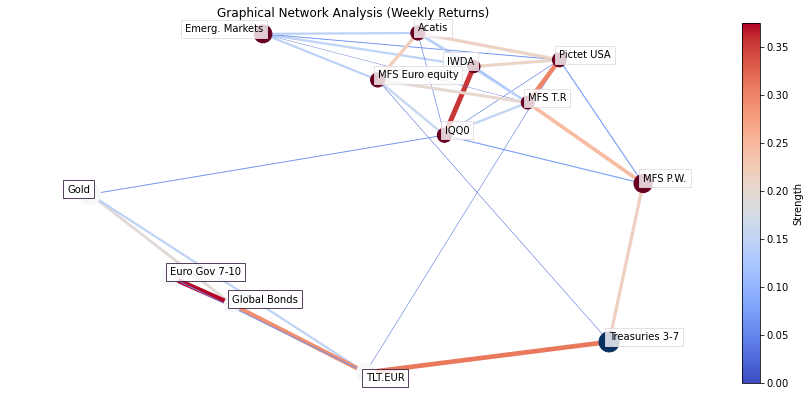

Wall time: 1.01 s


In [450]:
%%time
graphicalAnalysis(weekly_returns, start_date, end_date, display_IndRet=False, display_SumStat=False)